In [3]:
import math

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import model_selection, preprocessing, svm
from nltk import tokenize
from tqdm.notebook import tqdm

from pan20 import fake, util
from pan20.util.lexicons import lexical_negation, noble, sentiwordnet, wordnet_affect
from pan20.util import ctree, text

In [2]:
df = fake.load()

In [4]:
# or load
df = pd.read_csv('data/fake/feats.csv')

In [8]:
df.head()

,author,tweet,label,rt,adverbs,articles,auxiliary_verbs,conjunctions,impersonal_pronouns,personal_pronouns,prepositions,quantifiers,n,function_words,avg_bf,height,max_np_height,max_pp_height,max_vp_height
0,f4zgi7ym7829iqld6x77q6mh30s0rf86,"Thanks ""ArtistRack"" For Following Me !!! #URL#",0,False,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,13,0.000000,3.400000,7,7,6,4
1,f4zgi7ym7829iqld6x77q6mh30s0rf86,"Thanks ""Sally Mansfield"" For Following Me !!! ...",0,False,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,14,0.000000,2.571429,7,7,6,4
2,f4zgi7ym7829iqld6x77q6mh30s0rf86,"Thanks ""Simão"" For Following Me !!! #URL#",0,False,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,13,0.000000,2.500000,8,8,7,4
3,f4zgi7ym7829iqld6x77q6mh30s0rf86,"RT BBCWorld ""Danish prince refuses to be burie...",0,True,0.0,0.052632,0.052632,0.000000,0.0,0.105263,0.105263,0.0,19,0.315789,4.000000,5,4,0,0
4,f4zgi7ym7829iqld6x77q6mh30s0rf86,"RT Reuters ""Bieber says he's 'never going to b...",0,True,0.0,0.000000,0.043478,0.043478,0.0,0.043478,0.086957,0.0,23,0.217391,3.444444,8,4,0,7


In [13]:
def plot_mu_std(pdf, attr, group=True, std=True):
    if group:
        mdf = pdf.groupby(['author', 'label']).mean().reset_index()
    else:
        mdf = pdf
    sns.distplot(mdf[mdf.label == 0][attr], label='Not Spreader')
    sns.distplot(mdf[mdf.label == 1][attr], label='Spreader')
    plt.legend()
    plt.title(f'Distributions of means of {attr}')
    plt.show()
    if std:
        if group:
            sdf = pdf.groupby(['author', 'label']).std().reset_index()
        else:
            sdf = pdf
        sns.distplot(sdf[sdf.label == 0][attr], label='Not Spreader')
        sns.distplot(sdf[sdf.label == 1][attr], label='Spreader')
        plt.legend()
        plt.title(f'Distributions of stds of {attr}')
        plt.show()

In [5]:
def standardize(feats):
    max_ = np.expand_dims(feats.max(axis=0), 0)
    min_ = np.expand_dims(feats.min(axis=0), 0)
    return (feats - min_) / (max_ - min_)

## RT Freq.

Concerned it won't generalize, though. Issue being last 100 tweets might not be stable enough of a sample.

In [6]:
df['rt'] = df.tweet.apply(util.is_retweet)

In [7]:
rt_freqs = df.groupby(['author', 'label']).mean().reset_index()

In [8]:
rt_freqs.groupby(['label']).mean().rt

label
0    0.154533
1    0.072333
Name: rt, dtype: float64

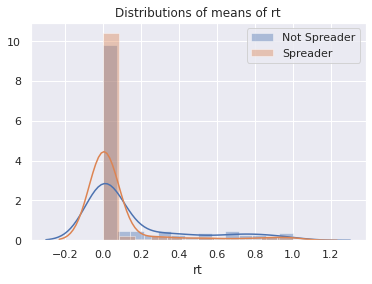

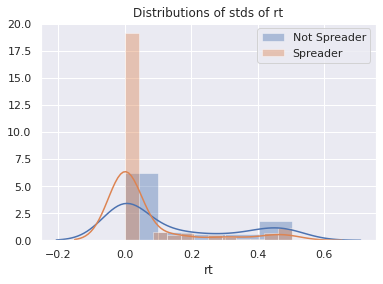

In [40]:
plot_mu_std(df, 'rt')

Not sure how much stock I want to put into this feature, or what it would really mean.

## Function Word Freq

In [10]:
fn = noble.CatFreqs()

In [11]:
freqs = []
with tqdm(total=len(df)) as pbar:
    for _, x in df.iterrows():
        freqs.append(fn(x.tweet))
        pbar.update()
print(len(freqs))


30000


In [12]:
for cat in noble.cats:
    df[cat] = [f[cat] for f in freqs]
df['n'] = [f['n'] for f in freqs]
df['function_words'] = [f['function_words'] for f in freqs]

In [14]:
df.to_csv('data/fake/feats.csv')

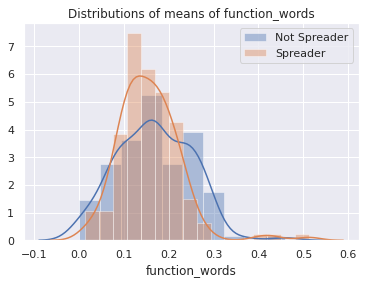

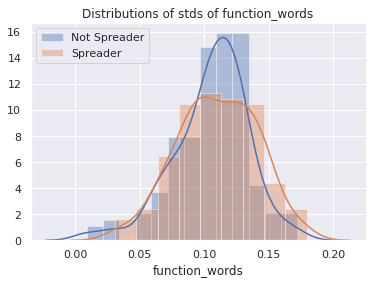

In [38]:
plot_mu_std(df, 'function_words')

In [142]:
noble.cats

['adverbs',
 'articles',
 'auxiliary_verbs',
 'conjunctions',
 'impersonal_pronouns',
 'personal_pronouns',
 'prepositions',
 'quantifiers']

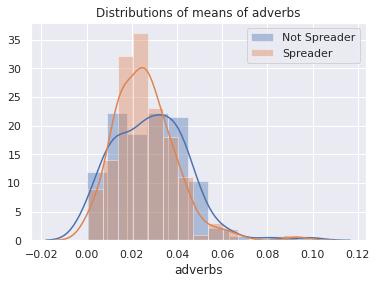

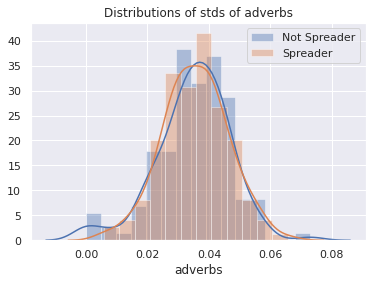

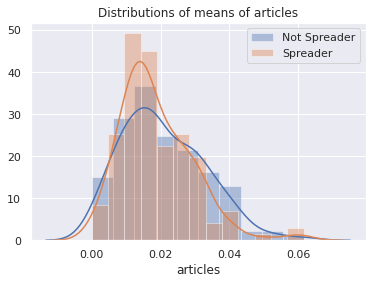

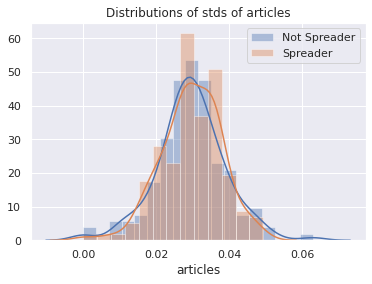

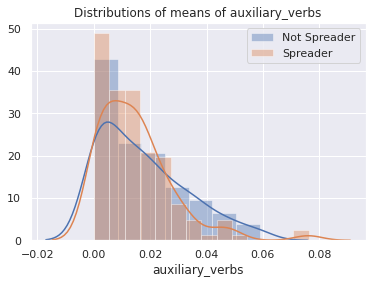

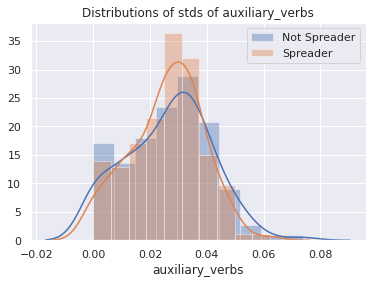

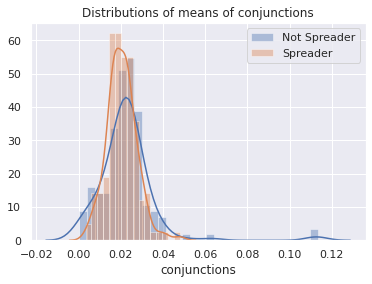

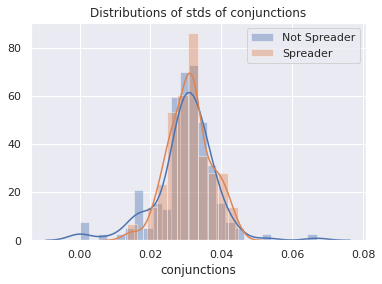

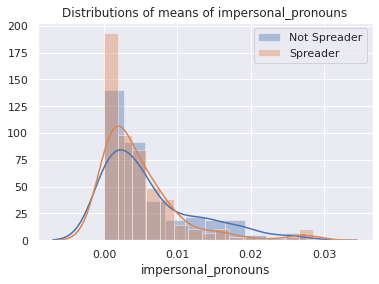

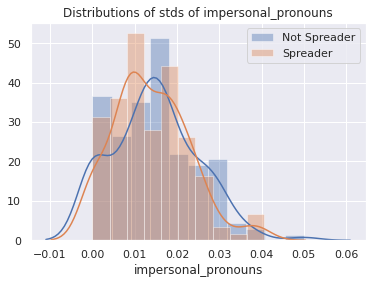

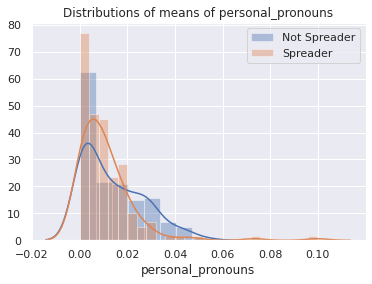

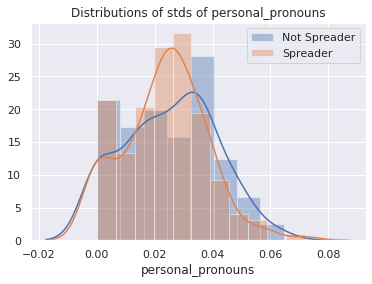

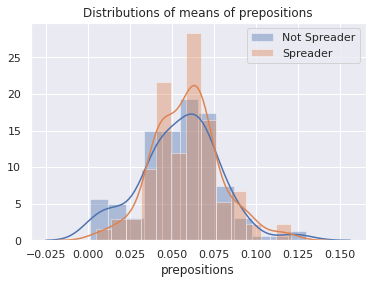

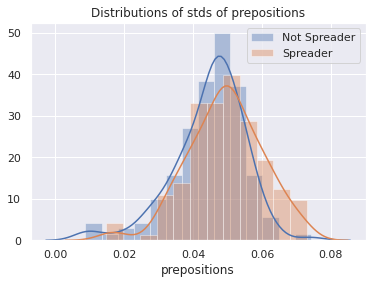

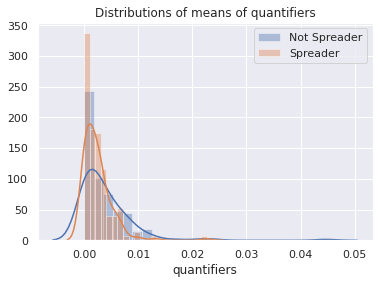

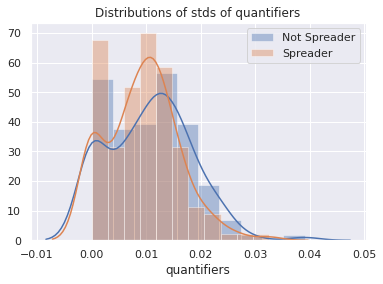

In [14]:
for cat in noble.cats:
    plot_mu_std(df, cat)

In [183]:
feats = [
    #adverbs',
    #'articles',
    #'auxiliary_verbs',
    #'conjunctions',
    'impersonal_pronouns',
    'personal_pronouns',
    'prepositions',
    #'quantifiers',
    'function_words',
    
    'avg_bf', 
    #'height', 
    'max_np_height', 
    #'max_pp_height', 
    'max_vp_height',
    
    'anger', 
    #'disgust', 
    #'fear', 
    #'joy', 
    #'sadness', 
    #'surprise',
]
X = dft[feats].values
X = standardize(X)
y = dft.label.values
svc = svm.SVC(C=1., kernel='rbf')
s = model_selection.cross_val_score(svc, X, y)
print(s)
np.mean(s)

[0.75       0.68333333 0.65       0.56666667 0.65      ]


0.66

In [187]:
for _, x in dft[dft.label == 1].sample(50).iterrows():
    print('-' * 8)
    print(' '.join(x.toks))

--------
everything you love is here # url #
--------
rt # user # : trouble , as boko haram rejects the payment of ransom for the release of leah sharibu # url #
--------
everything you love is here # url #
--------
rt # user # : # user # ordered to go to bayelsa for # user # ’ s swearing-in , to prove “ he is for everybody ” # url # …
--------
michaelfaudet : my new book bitter sweet love is available now .... # url #
--------
paul wesley and phoebe tonkin split again after four years of dating # url #
--------
rt nytimes `` rt nytclimate : trump tends to cherry pick his facts when it comes to climate change and the environmen… # url # ''
--------
thunder : “ it was the kind of kiss that made me know that i was never so happy in my whole life. ” — ... # url #
--------
rt # user # : # hashtag # : # user # , # user # , receive big support for the 2023 presidency # url #
--------
rt # user # : new bayelsa state governor begs jonathan , lyon , sylva , promises to appoint apc members # url

## Constituency Tree Features

In [16]:
get_tree = ctree.GetTree()

In [20]:
trees = []
with tqdm(total=len(df)) as pbar:
    for _, x in df.iterrows():
        trees.append(get_tree(x.tweet))
        pbar.update()

Feats:
- branching factor
- height
- max NP height
- max PP height
- max VP height

In [27]:
df['avg_bf'] = [ctree.avg_branch_factor(t) for t in trees]
df['height'] = [t.height() for t in trees]
df['max_np_height'] = [ctree.max_const_height(t, 'NP') for t in trees]
df['max_pp_height'] = [ctree.max_const_height(t, 'PP') for t in trees]
df['max_vp_height'] = [ctree.max_const_height(t, 'VP') for t in trees]

In [39]:
df.to_csv('data/fake/feats.csv')

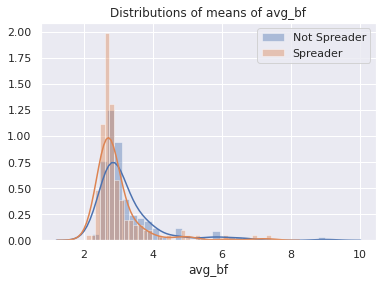

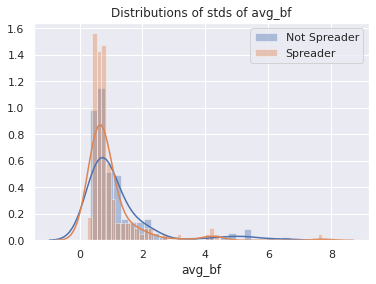

In [33]:
plot_mu_std(df, 'avg_bf')

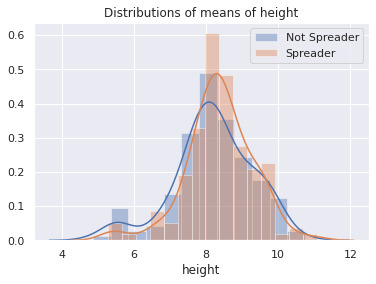

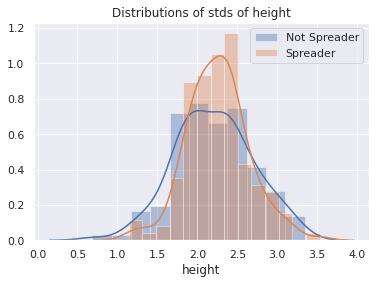

In [34]:
plot_mu_std(df, 'height')

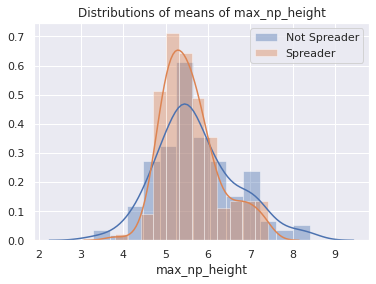

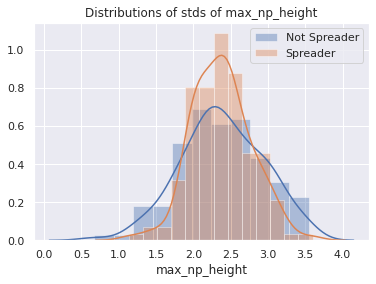

In [35]:
plot_mu_std(df, 'max_np_height')

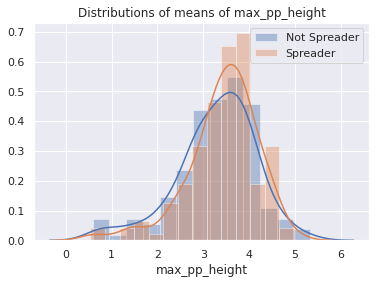

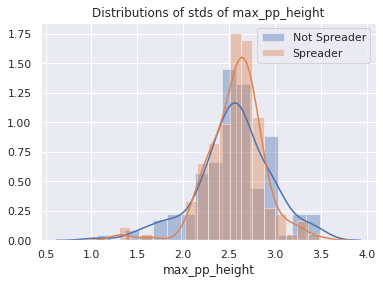

In [36]:
plot_mu_std(df, 'max_pp_height')

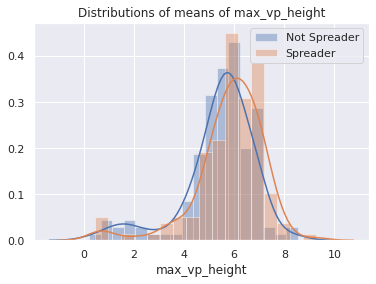

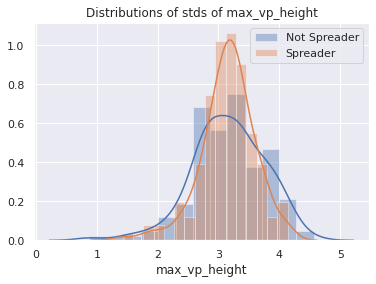

In [37]:
plot_mu_std(df, 'max_vp_height')

In [96]:
# how do these features fare on their own?
dft = pd.read_csv('data/fake/feats.csv')
dft.drop(columns=['Unnamed: 0'], inplace=True)
dft = dft.groupby(['author', 'label']).mean().reset_index()
dft.head()

,author,label,rt,adverbs,articles,auxiliary_verbs,conjunctions,impersonal_pronouns,personal_pronouns,prepositions,quantifiers,n,function_words,avg_bf,height,max_np_height,max_pp_height,max_vp_height
0,06ct0t68y1acizh9eow3g5rhancrppr8,1,0.00,0.024354,0.030895,0.024586,0.023115,0.002332,0.012252,0.062465,0.002456,24.37,0.182455,2.703347,9.70,5.72,4.45,7.09
1,071nxc49ihpd0jlfmvn2lghtayy3b5n9,0,0.02,0.017277,0.021188,0.001616,0.016693,0.001111,0.000741,0.042430,0.000000,18.18,0.101054,2.817067,7.76,4.65,3.91,5.55
2,09py5qescynpnnckmzueqzr2y49moh1o,0,0.00,0.012934,0.013555,0.002698,0.027646,0.002108,0.009790,0.026775,0.000833,20.81,0.096338,3.179291,8.17,5.10,3.18,5.36
3,0dwovd7nj6yg9m795ng2c629me0ccmrh,0,0.81,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001501,0.000000,24.73,0.001501,2.652800,9.67,7.20,4.49,6.84
4,0ibi364m7i7l01xi4xqafyathrmrrnll,1,0.53,0.023210,0.023358,0.016227,0.018730,0.005401,0.010445,0.050341,0.002772,26.99,0.150484,3.155324,9.19,6.64,3.93,6.32


In [127]:
svc = svm.SVC(C=0.5, kernel='rbf')
X = dft[[
    'avg_bf', 
    #'height', 
    'max_np_height', 
    #'max_pp_height', 
    'max_vp_height'
    ]].values
X = standardize(X)
y = dft.label.values
s = model_selection.cross_val_score(svc, X, y, cv=5)
print(s)
np.mean(s)

[0.63333333 0.61666667 0.71666667 0.63333333 0.53333333]


0.6266666666666667

## Punctuation

In [41]:
import string

print(len(string.punctuation))
print(string.punctuation)

32
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


The only psychologically meaningful one I think is `!`.

In [48]:
df['exclaims'] = df.tweet.apply(lambda x: sum(1 for c in x if c == '!') / len(x))

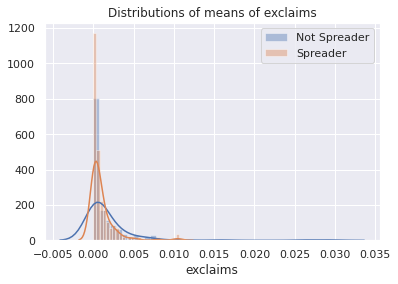

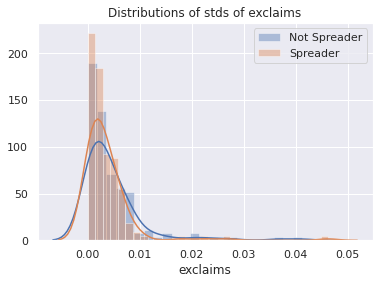

In [49]:
plot_mu_std(df, 'exclaims')

In [ ]:
df.to_csv('data/fake/feats.csv')

In [2]:
df = pd.read_csv('data/fake/feats.csv')

## LIWC

In [26]:
liwc_out = pd.read_csv('data/fake/liwc_out.csv')
liwc_out = liwc_out[liwc_out.Filename != 'author.txt']

In [27]:
truth = {x.author: x.label for _, x in df.groupby(['author', 'label']).mean().reset_index().iterrows()}

In [28]:
liwc_out['label'] = liwc_out.Filename.apply(lambda x: truth[x.split('.')[0]])

In [32]:
wanted = ['label', 'Tone', 'function', 'pronoun', 'shehe', 'sad',
          'auxverb', 'negate', 'quant', 'posemo', 'negemo', 'anx', 'anger']
dfl = liwc_out[wanted]

In [137]:
wanted_X = ['anger', 'negemo', 'anx']
dfX = dfl[[c for c in dfl.columns if c in wanted_X]]
print(dfX.columns)
X = dfX.values
X = standardize(X)
y = dfl.label.values
svc = svm.SVC(C=0.9, kernel='rbf')
s = model_selection.cross_val_score(svc, X, y, cv=5)
print(s)
print(np.mean(s))

Index(['negemo', 'anx', 'anger'], dtype='object')
[0.73333333 0.71666667 0.7        0.74576271 0.61016949]
0.7011864406779662


19


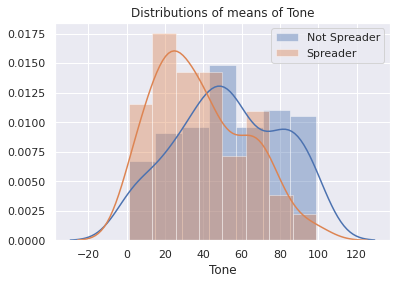

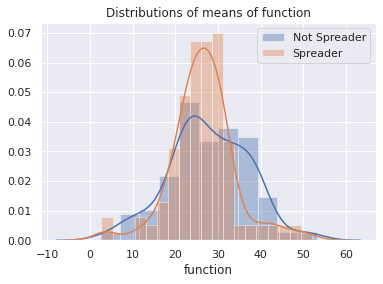

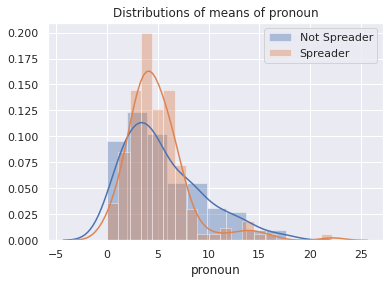

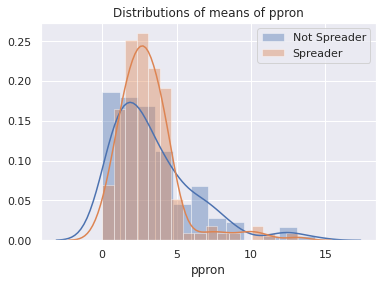

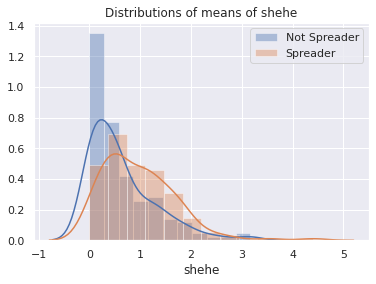

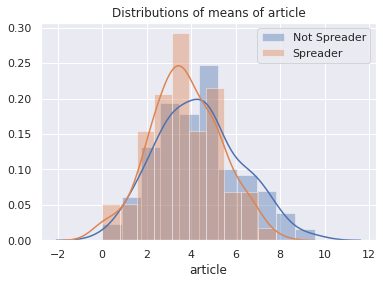

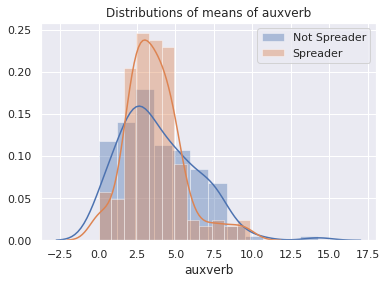

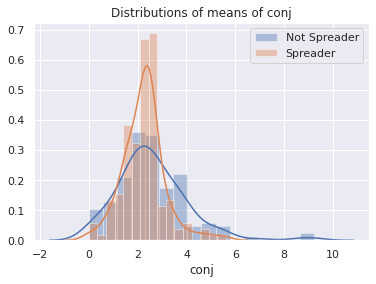

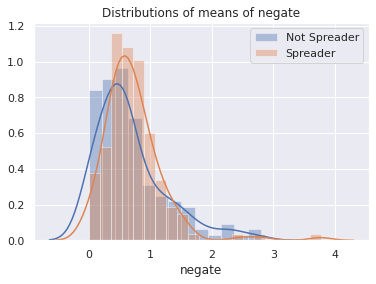

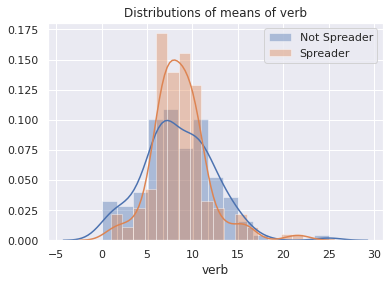

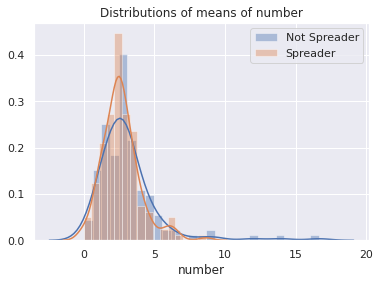

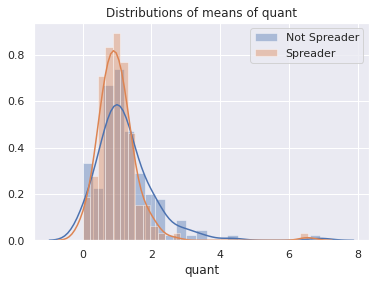

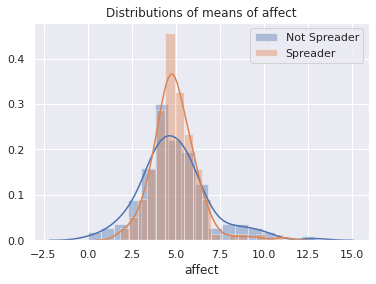

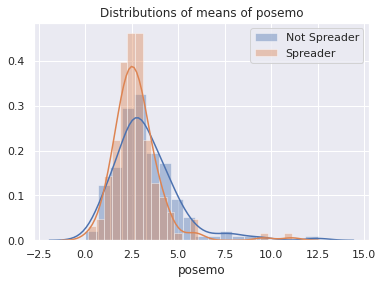

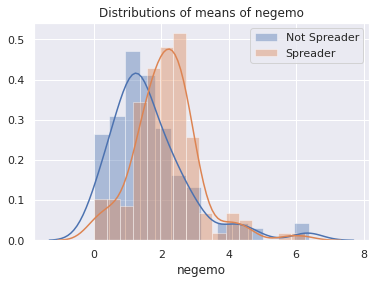

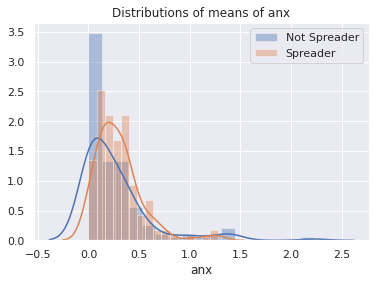

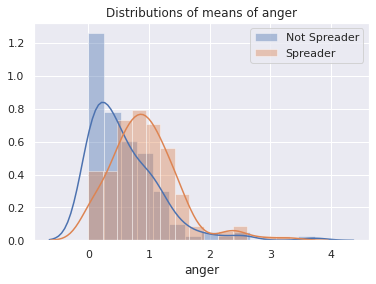

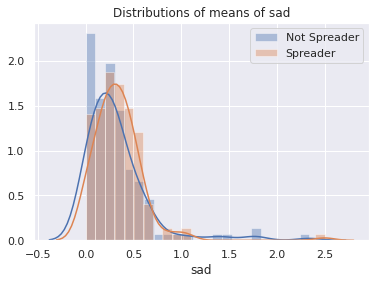

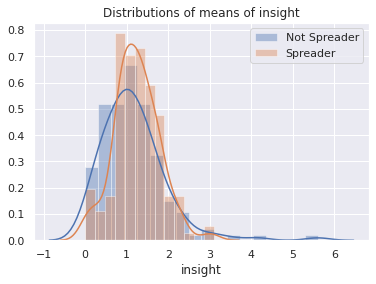

In [89]:
# posthoc list
unwanted = [
    'WC', 'Filename', 'Segment', 'label',
    'Analytic', 'Clout', 'Authentic',
    'i', 'you', 'we', 'they', 'ipron',
    'prep', 'adverb', 'differ', 'tentat',
    'discrep', 'adj', 'compare', 'interrog',
    'cogproc', 'cause', 'certain',
]
targets = [c for c in liwc_out.columns if c not in unwanted]
print(len(targets))
for target in targets:
    plot_mu_std(liwc_out, target, False, False)

## Open Source Pos-Neg Lexicon: SentiWordNet

In [72]:
swn = sentiwordnet.SentiWordNet()

In [55]:
df['toks'] = df.tweet.apply(lambda x: tokenize.word_tokenize(x))

In [73]:
df['senti'] = df.toks.apply(swn.score)
df['senti_neg'] = df.toks.apply(swn.score_neg)
df['senti_pos'] = df.toks.apply(swn.score_pos)

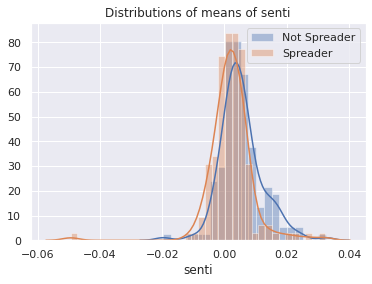

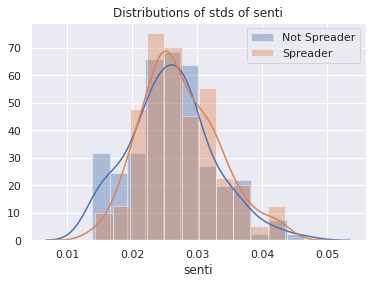

In [74]:
plot_mu_std(df, 'senti')

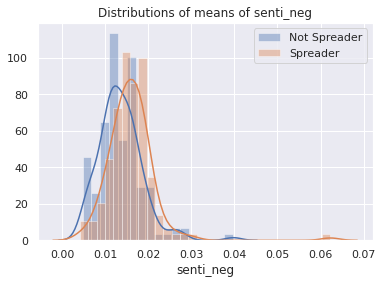

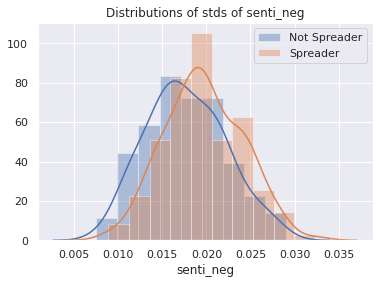

In [75]:
plot_mu_std(df, 'senti_neg')

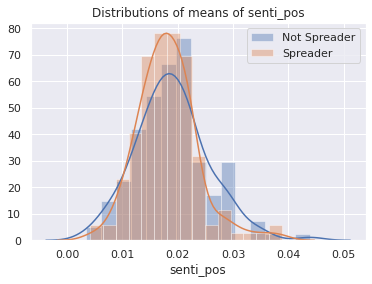

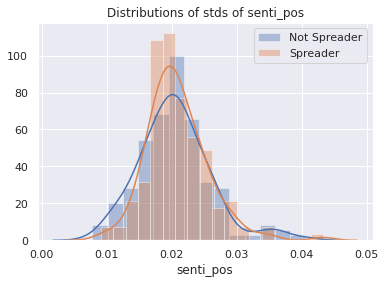

In [76]:
plot_mu_std(df, 'senti_pos')

Doesn't seem to be as good of a feature as LIWC, but it is some of the way. Here we have sentiment words, but I think they use more psychologically motivated words, ones that perhaps represent a psychological state as opposed to a negative judgment. It would be valuable to look at more psycho-linguistic stuff in this respect, to find a better profile.

## Open Source Negation

This feature looked pretty good from the LIWC analysis.

In [79]:
negations = ['n\'t', 'no', 'not', 'never', 'nowhere', 'nobody']

In [80]:
# first step is to simply use that quick custom list
df['negate'] = df.toks.apply(lambda x: sum(1 for t in x if t in negations) / len(x))

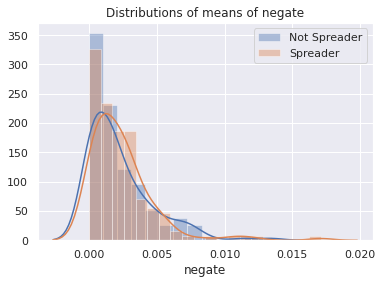

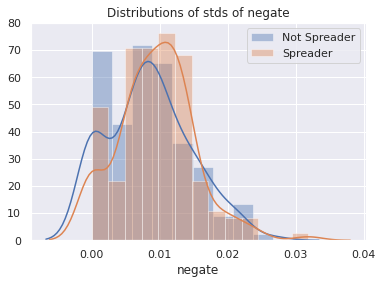

In [81]:
plot_mu_std(df, 'negate')

Let's add the lexical negation dict.

In [95]:
ln = lexical_negation.LexicalNegations()

In [96]:
df['ln_pos'] = df.toks.apply(lambda x: sum(t in ln.pos for t in x) / len(x))
df['ln_neg'] = df.toks.apply(lambda x: sum(t in ln.neg for t in x) / len(x))

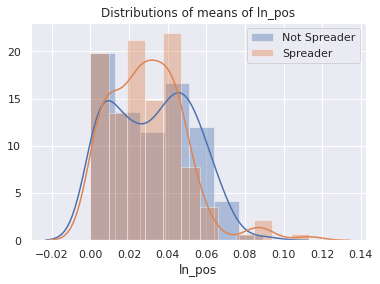

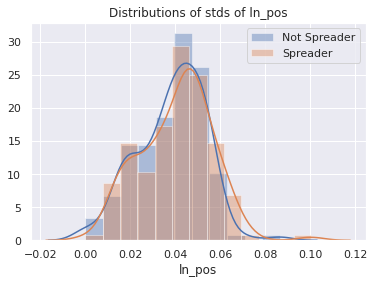

In [97]:
plot_mu_std(df, 'ln_pos')

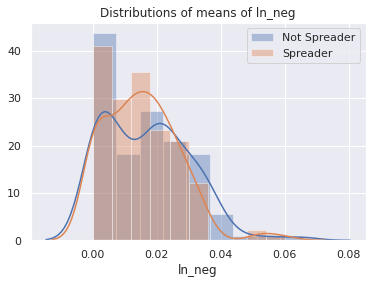

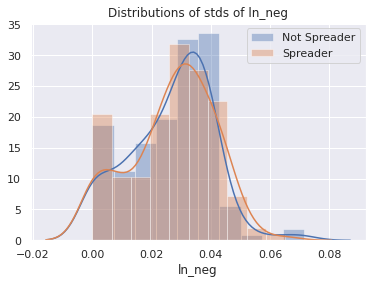

In [98]:
plot_mu_std(df, 'ln_neg')

## Articles

LIWC indicated interesting, also have a psychological interpretation: concreteness.

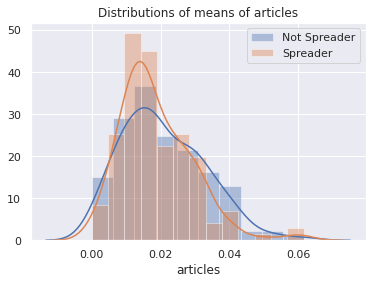

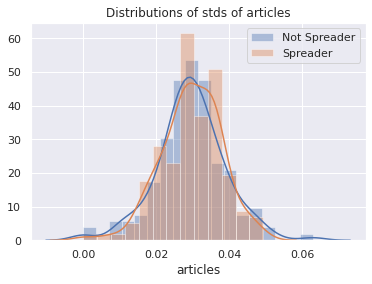

In [101]:
plot_mu_std(df, 'articles')

Pretty close to the same as LIWC.

## VERB freqs

The LIWC analysis indicated perhaps verb usage rates are different.

In [125]:
preds = [
    {'author': 'abc', 'pred': 1},
    {'author': 'def', 'pred': 1},
]
outputs.save(preds)

In [113]:
df['pos'] = df.toks.apply(lambda x: [t[1] for t in nltk.pos_tag(x)])

In [121]:
verb_pos = ['VB', 'VBP', 'VBN', 'VBZ', 'VBG']

def verb_freq(pos):
    return sum(1 for p in pos if p in verb_pos) / len(pos)

df['verb_freq'] = df.pos.apply(verb_freq)

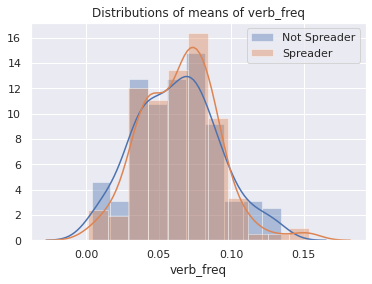

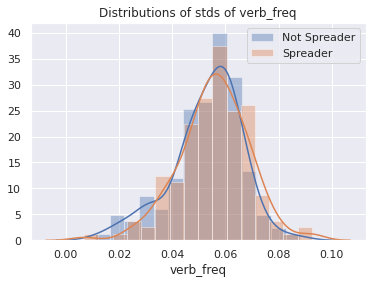

In [122]:
plot_mu_std(df, 'verb_freq')

Not looking as good as LIWC.

## Number and Quant

Also from LIWC analysis.

## Negemo - different from negative sentiment

## Anger words

## Anxiety words

## WordNet Affect

In [167]:
wn_affect = wordnet_affect.WordNetAffect()

In [168]:
wn_affect.categories

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

In [169]:
dft['toks'] = df.tweet.apply(lambda x: [t.lower() for t in tokenize.word_tokenize(x)])

In [170]:
for cat in wn_affect.categories:
    dft[cat] = df.toks.apply(lambda x: wn_affect.cat_freq(x, cat))

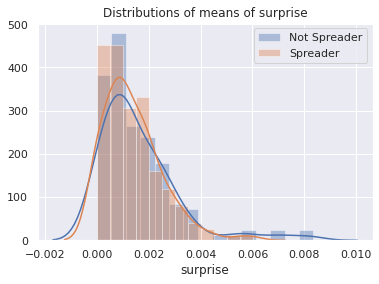

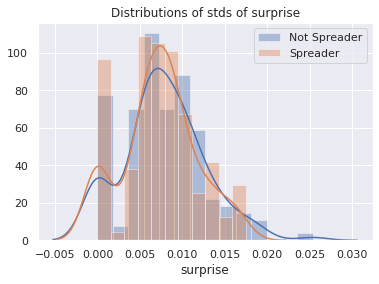

In [25]:
plot_mu_std(df, 'surprise')

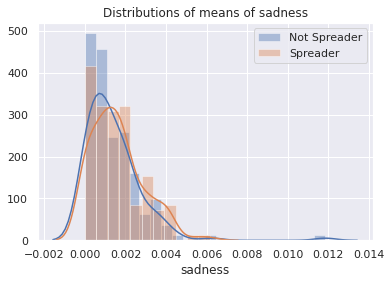

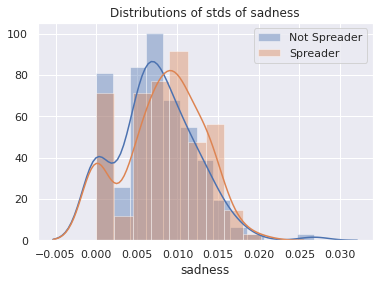

In [24]:
plot_mu_std(df, 'sadness')

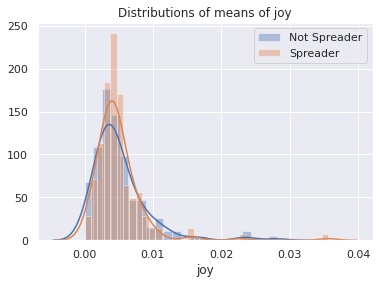

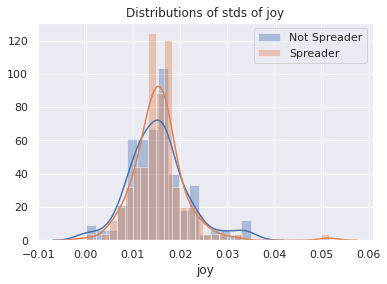

In [23]:
plot_mu_std(df, 'joy')

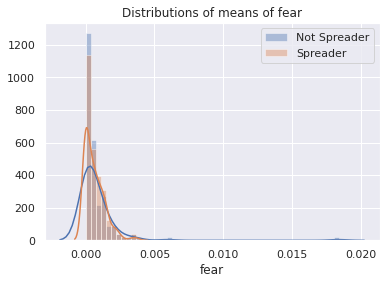

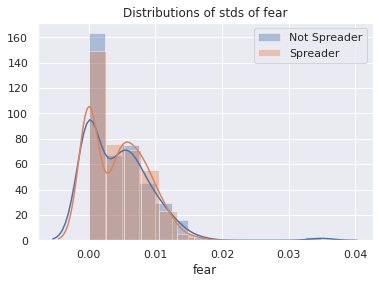

In [22]:
plot_mu_std(df, 'fear')

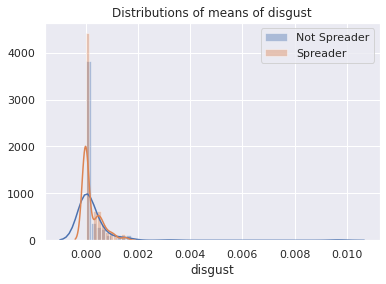

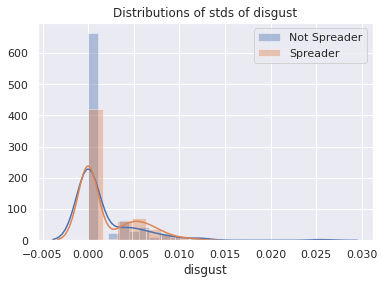

In [21]:
plot_mu_std(df, 'disgust')

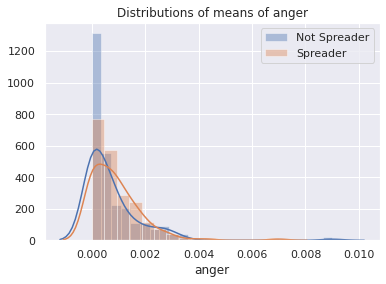

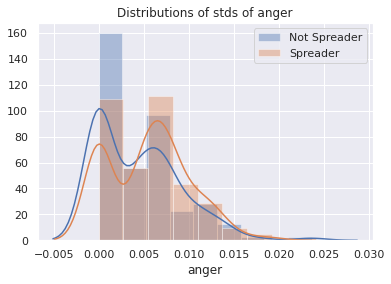

In [20]:
plot_mu_std(df, 'anger')

## Variety of Sources Quoted

In [10]:
# need a function to extract who has been quoted
for _, x in df.sample(20).iterrows():
    print('-' * 8)
    print(x.tweet)

--------
#USER# New post: Your waist size may be more important than weight for multiple heart attack risk #URL#
--------
Keanu Reeves, Carrie-Anne Moss On Set for 'Matrix 4' in San Francisco #URL#
--------
🚨740 GAME ROOM🚨  🏒SEMIFINALS🏒  🎮 - #USER#   6PM - HERE - TONIGHT  The #USER# (#USER# of #USER#) tak… #URL#
--------
Critical Distance: INFERNO, Why It's Good to See Bad Movies: The word is out on Ron Howard's Inferno. Only 20... #URL#
--------
Normani, #HASHTAG#, Chaka Khan &amp; more: Vote for the #HASHTAG# guest judge you're most excited to see 🎉 #URL#
--------
Pakistan Arrests 6 Men for Raising Funds for Outlawed Group #URL#
--------
90210's SHANNEN DOHERTY Joins CW's RIVERDALE For LUKE PERRY Tribute Episode #URL# #HASHTAG#
--------
#USER# #USER# #USER# “You have to be safe and you have to stay safe everywhere you go. You… #URL#
--------
#HASHTAG# iPhone 8, iPhone 8 Plus Arrives at Boost Mobile on Friday, Sept. 29 . Read more: #URL# $AAPL
--------
Another 67 people test positive 

Patterns:
- Starts with "RelNews: "
  * This tweet might be off-putting though: "heaveninawildflower: ‘Spring Moon at Ninomiya Beach’ (1932).... #URL#". Methinks they might've wanted to put #USER# at the start or something.
  * Is this a news source or a concept: "Review: The tear-jerking 'Good Place' series finale stays far away from the Bad Place #URL# #URL#"
- "-CBS News-" in the middle, before a "#URL#"
- After headline: " - NPR #URL# #URL#"
  * This though: "lant and Procurement Co-ordinator – KN Group – Dublin #URL#"

OK, so the patterns aren't going to work. Will actually need to identify the entities involved. How to...
- NER? Get a list of entities from the existing tweets. Use those as features? Or attempt something more significant?

Let's see how the NER goes.

In [11]:
import spacy

In [15]:
nlp = spacy.load('en_core_web_sm')

In [16]:
s = nlp("Taylor  Swift  's  Grammy  Evolution  :  A  Look  Back  at  Her  Award  Show  Style  #  URL  #  #  URL  #")

In [67]:
counts = {}
with tqdm(total=len(df)) as pbar:
    for _, x in df.iterrows():
        doc = nlp(x.tweet)
        for ent in doc.ents:
            k = f'{ent.text}_{ent.label_}'
            if k not in counts:
                counts[k] = {'no': 0, 'yes': 0, 'n': 0}
            counts[k]['n'] += 1
            if x.label:
                counts[k]['yes'] += 1
            else:
                counts[k]['no'] += 1 
        pbar.update()

In [71]:
et = pd.DataFrame([
    {'entity': k, 'n': v['n'], 'no': v['no'], 'yes': v['yes']}
    for k, v in counts.items()
])

In [106]:
et2 = et[et.n > 10].copy()
et2['has_hash'] = et2.entity.apply(lambda x: '#' in x)
et2 = et2[et2.has_hash == False]
et2['is_number'] = et2.entity.apply(lambda x: all(c in '1234567890' for c in x))
et2 = et2[et2.is_number == False]
et2['is_lower'] = et2.entity.apply(lambda x: x[0].islower())
et2 = et2[et2.is_lower == False]
et2['is_cardinal'] = et2.entity.apply(lambda x: 'CARDINAL' in x)
et2 = et2[et2.is_cardinal == False]
et2['is_date'] = et2.entity.apply(lambda x: 'DATE' in x)
et2 = et2[et2.is_date == False]
et2.drop(columns=['has_hash', 'is_number', 'is_lower', 'is_cardinal', 'is_date'], 
         inplace=True)
unwanted = ['HASHTAG', 'READ &gt;&gt_ORG']
et2 = et2[~et2.entity.isin(unwanted)]
print(len(et2))
et2 = et2.sort_values(by=['entity'])
et2

370


,entity,n,no,yes
6096,10%_PERCENT,15,13,2
3167,100%_PERCENT,12,3,9
1344,1st_ORDINAL,15,4,11
3861,25th_ORDINAL,18,0,18
2044,ABC_ORG,25,12,13
...,...,...,...,...
870,World Cup_EVENT,25,12,13
4357,World Series_EVENT,12,2,10
1169,Wuhan_GPE,13,11,2
400,Zayn Malik_PERSON,20,3,17


In [107]:
for _, x in et2.iterrows():
    if 'ORG' not in x.entity:
        continue
    print(f'{x.n} {x.entity}: %s-%s' % (x['no'], x['yes']))

25 ABC_ORG: 12-13
11 APC_ORG: 10-1
23 AP_ORG: 2-21
13 Alexa_ORG: 5-8
78 Amazon_ORG: 43-35
14 American Idol_ORG: 0-14
13 Android_ORG: 5-8
133 Apple_ORG: 81-52
14 BBC_ORG: 9-5
12 Beyoncé_ORG: 0-12
24 Bloomberg_ORG: 9-15
22 CBS_ORG: 11-11
15 CDC_ORG: 7-8
20 CIA_ORG: 1-19
26 CNBC_ORG: 18-8
91 CNN_ORG: 28-63
57 Congress_ORG: 11-46
34 Coronavirus_ORG: 10-24
11 DNC_ORG: 2-9
16 Disney_ORG: 7-9
36 EU_ORG: 16-20
81 FBI_ORG: 14-67
12 Facebook_ORG: 6-6
13 Fallout 4 Video Game Launch Event - Los Angeles_ORG: 0-13
12 Ferrari_ORG: 5-7
14 Ford_ORG: 8-6
32 Fox News_ORG: 12-20
17 Fox_ORG: 5-12
68 GOP_ORG: 14-54
12 General Hospital Spoilers_ORG: 12-0
91 Google_ORG: 60-31
19 HBO_ORG: 15-4
64 House_ORG: 17-47
14 Jonas Brothers Reunite_ORG: 0-14
15 Jordyn Woods'_ORG: 0-15
13 LACMA 2015_ORG: 0-13
12 LSU_ORG: 7-5
13 Lizzo_ORG: 3-10
14 MTV_ORG: 4-10
11 Meghan Markle's_ORG: 0-11
33 Microsoft_ORG: 22-11
11 Mitt Romney_ORG: 2-9
15 MovieMagic_ORG: 0-15
62 NASA_ORG: 42-20
37 NBA_ORG: 20-17
14 NBC News_ORG: 6-8
15 N

Attempt 1: count the number of ORGs mentioned by a user. Will be pretty rough.

In [83]:
x_ents = []
with tqdm(total=len(df)) as pbar:
    for _, x in df.iterrows():
        doc = nlp(x.tweet)
        x_ents.append(doc.ents)
        pbar.update()

In [88]:
user_ents = {}
with tqdm(total=len(df)) as pbar:
    for _, x in df.iterrows():
        doc = nlp(x.tweet)
        if x.author not in user_ents:
            user_ents[x.author] = []
        user_ents[x.author].append(doc.ents)
        pbar.update()

In [94]:
auth_label = {}
for _, x in df.iterrows():
    auth_label[x.author] = x.label

In [104]:
def get_org_count(author):
    ents = user_ents[author]
    ents = [e for s in set(ents) for e in s]
    return sum(1 for e in ents if e.label_ == 'ORG')

def get_n_ents(author):
    ents = user_ents[author]
    ents = [e for s in set(ents) for e in s]
    return len(ents)

dfu = []
for author in df.author.unique():
    dfu.append({
        'author': author,
        'n_orgs': get_org_count(author),
        'n_ents': get_n_ents(author),
        'label': auth_label[author],
    })
dfu = pd.DataFrame(dfu)

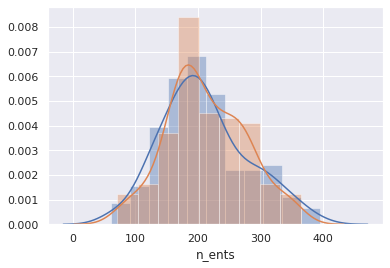

In [105]:
sns.distplot(dfu[dfu.label == 0].n_ents, label='Not Spreader')
sns.distplot(dfu[dfu.label == 1].n_ents, label='Spreader')
plt.show()

Now working with vector of medias:

In [108]:
media = [
    'ABC',
    'BBC',
    'Bloomberg',
    'CBS',
    'CNBC',
    'CNN',
    'Fox News',
    'Fox',
    'NBC News',
    'NBC',
    'RCN America',
    'RCN America - Maine',
    'Reuters',
    'The New York Times',
    'The Washington Post',
    'Washington Post',
]

First try is just frequency of mentioning the above, i.e. # mentions / 100 tweets.

In [110]:
media_dict = util.IxDict(media)

In [118]:
def get_vec(author):
    ents = user_ents[author]
    ents = [e for s in set(ents) for e in s]
    vec = np.zeros((1, len(media)))
    for ent in ents:
        if ent.text in media_dict:
            ix = media_dict[ent.text]
            vec[0, ix] += 1
    return vec

X = []
y = []

for author in df.author.unique():
    label = auth_label[author]
    vec = get_vec(author)
    X.append(vec)
    y.append(label)

X = np.concatenate(X, axis=0)
y = np.array(y)

In [122]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [124]:
from sklearn import svm

In [125]:
svc = svm.SVC(C=1., kernel='rbf')
svc.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [129]:
from sklearn import model_selection

s = model_selection.cross_val_score(svc, X, y, cv=5)
print(s)
np.mean(s)

[0.5        0.53333333 0.58333333 0.51666667 0.55      ]


0.5366666666666667

I'm about ready to say that this hypothsis is ready to throw out.

## Trust and Distrust

I will build a custom lexicon from a thesaurus.

In [137]:
distrust = [
    'mistrust', 'mistrusts', 'mistrusting',
    'distrust', 'distrusts', 'distrusting',
    'suspect', 'suspects', 'suspected', 'suspecting', 
    'suspicion', 'suspicions', 'suspicious', 'suspiciousness',
    'fake', 'fakes', 'faked', 'faking', 'fakeness',
    'disbelieve', 'disbelieved', 'disbelieving', 'disbeliever', 'disbelievers',
    'unbelievable', 'ubelieved', 'unbelieving', 'unbeliever', 'unbelievers',
    'doubt', 'doubts', 'doubtful', 'doubted', 'doubting', 'doubter', 'doubters', 
    'suppose', 'supposed', 'supposing', 'supposes',
    'so_called', 
    'misgiving', 'misgivings',
    'fear', 'fears', 'fearing', 'feared',
    'qualm', 'qualms',
    'question', 'questions', 'questioning', 'questioned', 'questioner', 'questioners',
    'inquire', 'inquires', 'inquired', 'inquirer', 'inquirers', 'inquiring',
    'skeptic', 'skeptics', 'skeptical',
    'wonder', 'wonders', 'wondering', 'wondered',
]

In [133]:
df['toks'] = df.tweet.apply(text.tokenize)

In [135]:
df['n_toks'] = df.toks.apply(lambda x: len(x))

In [138]:
df['distrust'] = df.toks.apply(lambda x: sum(1 for t in x if t in distrust))

In [139]:
g = df.groupby(['author', 'label']).sum().reset_index().copy()
g['distrust'] = g['distrust'] / g['n_toks']

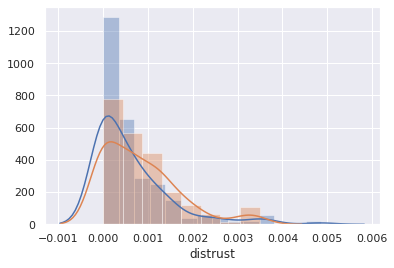

In [140]:
sns.distplot(g[g.label == False].distrust, label='Not Spreader')
sns.distplot(g[g.label == True].distrust, label='Spreader')
plt.show()

## Pronouns

Idea comes from [this paper]():

>  people who showed less diversity in their writing styles were more likely to have negative health outcomes.
The results held for all three groups, with correlations between the essays’ similarity and doctor visits in the range of .34 to .51. Subsequent analysis showed that changes in the use of pronouns and particles were the strongest predictors. While the true mechanism behind such strong eff ects is not fully understood, one explanation suggested by the authors is that change of the context in which pronouns are used can refl ect fl exibility in perspective taking and thus re-evaluation of emotional experiences. 

and is indicated as useful by the LIWC analysis above. More use of `ppron` is associated with non-spreader, more use of `heshe` is associated with spreader.

The LIWC categories and counts are:

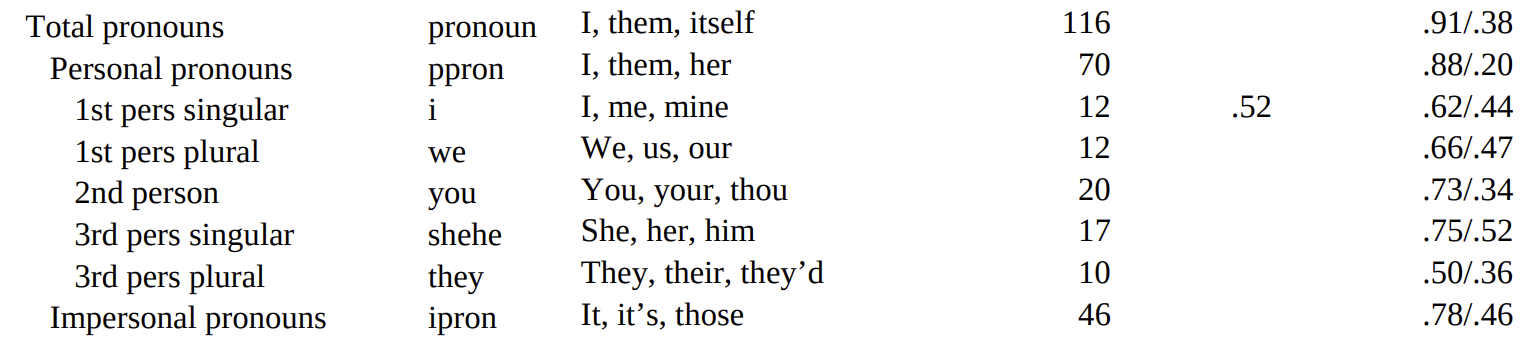

Free list of over 100 pronouns [here](https://www.thefreedictionary.com/List-of-pronouns.htm).

The Noble dict has 52 against the 70 in LIWC. It seems to be working OK though.

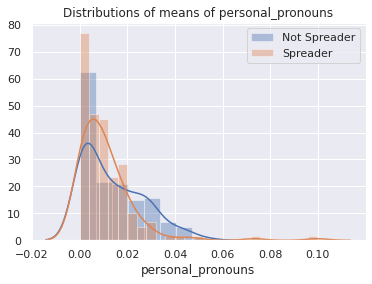

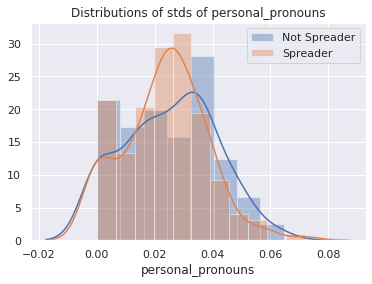

In [17]:
plot_mu_std(df, 'personal_pronouns')

- Commercial stuff in the positive cases?
- Use of emoji?